In [62]:
import os
import torch
import datetime
import pandas as pd
import utils as ut
import plotly.express as px

import geopandas as gp

import paths
from apollo import mechanics as ma
from apollo import streamflow as strf
from apollo import metrics as me

from train_model import load_data, train
from train_model import sensitivity_analysis as sa

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

pd.options.mode.chained_assignment = None

In [63]:
### Set global model parameters
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Rundown code and dataloading step by step

In [64]:
station = 8002
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
df

file      timestamp             2024-05-01T16:16:16
0        database             id                  nrfa-public-30
1        database           name  UK National River Flow Archive
2         station             id                            8002
3         station           name                 Spey at Kinrara
4         station  gridReference                    NH8809908201
...           ...            ...                             ...
25947  2022-09-26          9.597                             NaN
25948  2022-09-27         17.270                             NaN
25949  2022-09-28         19.650                             NaN
25950  2022-09-29         14.570                             NaN
25951  2022-09-30         48.430                             NaN

[25952 rows x 3 columns]

In [65]:
metadata = pd.read_csv(paths.DATA + '/Catchment_Database.csv')
specific = metadata[metadata['Station number'] == station]

In [66]:
filename = paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_lumped_linear.csv')
rf = pd.read_csv(filename)
#rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
rf = rf.drop(rf.index[:185])
len_before = len(rf)
rf = rf.dropna(subset=['Flow'])
print(len_before-len(rf), 'values are missing.')
rf

0 values are missing.


Unnamed: 0        Date   Flow  Temperature  U Windspeed  V Windspeed  \
185           364  1979-12-31  15.60   272.235682     1.761276    -0.427681   
186           365  1980-01-01  15.01   269.433771     1.095062    -0.541745   
187           366  1980-01-02  14.68   271.376272    -0.747654     0.560706   
188           367  1980-01-03  15.03   276.707108    -1.318302     1.813172   
189           368  1980-01-04  27.17   277.786927     1.471317     4.568316   
...           ...         ...    ...          ...          ...          ...   
15522       15701  2021-12-27  13.86   278.846867    -0.860816     1.320779   
15523       15702  2021-12-28  13.11   279.203095     0.132760    -0.157818   
15524       15703  2021-12-29  21.76   279.368323    -2.887024     2.943759   
15525       15704  2021-12-30  44.24   285.316724     3.595977     3.535512   
15526       15705  2021-12-31  31.46   284.669215    -0.895887     0.725066   

         Humidity      Rain     Snow Melt  Resultant Windspeed  ...  \
185     98.849896  0.239485  0.000000e+00             1.812458  ...   
186     98.696782  0.047673  5.204170e-15             1.221740  ...   
187     97.969934  0.250338  5.204170e-15             0.934546  ...   
188     95.806245  6.596495  3.617008e+00             2.241765  ...   
189     89.444684  2.165291  4.899825e+00             4.799404  ...   
...           ...       ...           ...                  ...  ...   
15522   97.654246  1.307572  7.732855e-01             1.576535  ...   
15523  100.202512  0.468725  4.985906e-01             0.206233  ...   
15524   97.014023  8.679468  5.905925e+00             4.123181  ...   
15525   95.863196  4.276647  4.064020e+00             5.042905  ...   
15526   99.418598  4.142114  7.278025e-01             1.152534  ...   

       Snow Melt-25  Snow Melt-26  Snow Melt-27  Snow Melt_28_Mu  \
185        0.002163      0.001041      0.152034         1.543927   
186        0.494738      0.002163      0.001041         1.538497   
187        4.137027      0.494738      0.002163         1.538460   
188        5.450705      4.137027      0.494738         1.667561   
189        2.619437      5.450705      4.137027         1.824886   
...             ...           ...           ...              ...   
15522      0.000091      0.530088      3.426892         0.929626   
15523      0.630858      0.000091      0.530088         0.825044   
15524      0.820511      0.630858      0.000091         1.017038   
15525      0.000000      0.820511      0.630858         1.162179   
15526      0.024339      0.000000      0.820511         1.165641   

       Snow Melt_90_Mu  Snow Melt_180_Mu  Soil Moisture 1  Soil Moisture 2  \
185           0.997957          0.499918         0.256701         0.266819   
186           0.997957          0.499918         0.252835         0.262295   
187           0.997957          0.499918         0.249506         0.258365   
188           1.038146          0.520013         0.246653         0.254959   
189           1.092589          0.547234         0.287056         0.278992   
...                ...               ...              ...              ...   
15522         0.354035          0.177017         0.261916         0.259338   
15523         0.359575          0.179787         0.264609         0.259148   
15524         0.425196          0.212598         0.302211         0.260436   
15525         0.470352          0.235176         0.330638         0.325138   
15526         0.478438          0.239219         0.312174         0.307430   

       Soil Moisture 3  Soil Moisture 4  
185           0.274988         0.298031  
186           0.272321         0.297785  
187           0.269526         0.297526  
188           0.266642         0.297240  
189           0.264425         0.296926  
...                ...              ...  
15522         0.282099         0.294597  
15523         0.279686         0.294478  
15524         0.277288         0.294328  
15525         0.281910         

In [67]:
hourly_df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + f"/{station}_daily_rain_9to9_linear.csv")
hourly_df = hourly_df.rename(columns={'date': 'Date'})
hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date
hourly_df = hourly_df.drop(rf.index[:365])
hourly_df

Date      Rain_-24  Rain_-23      Rain_-22  Rain_-21  Rain_-20  \
0      1979-01-01           NaN       NaN           NaN       NaN       NaN   
1      1979-01-02  8.673617e-16  0.000270  2.696505e-04  0.000449  0.000449   
2      1979-01-03  1.269479e-01  0.230786  2.248842e-01  0.112390  0.042117   
3      1979-01-04  2.696505e-04  0.000270  9.887968e-04  0.002522  0.003536   
4      1979-01-05  1.086007e-02  0.001169  8.673617e-16  0.000270  0.000520   
...           ...           ...       ...           ...       ...       ...   
15701  2021-12-27  6.915851e-02  0.053911  2.224515e-02  0.006587  0.003503   
15702  2021-12-28  6.520279e-03  0.023016  3.201771e-02  0.018166  0.008283   
15703  2021-12-29  5.037284e-03  0.005523  3.571411e-03  0.004502  0.010769   
15704  2021-12-30  8.128581e-03  0.007396  3.857498e-03  0.006898  0.093730   
15705  2021-12-31  7.836597e-03  0.006184  5.301755e-03  0.003462  0.017243   

           Rain_-19  Rain_-18  Rain_-17      Rain_-16  ...  Rain_-10  \
0               NaN       NaN       NaN           NaN  ...  0.005406   
1      2.696505e-04  0.000449  0.000557  2.696505e-04  ...  0.372697   
2      1.268533e-02  0.000938  0.000388  8.673617e-16  ...  0.014306   
3      3.036385e-03  0.002484  0.123976  2.065169e-01  ...  1.117625   
4      2.696505e-04  0.000700  0.000520  5.199154e-04  ...  0.002047   
...             ...       ...       ...           ...  ...       ...   
15701  6.468375e-03  0.010826  0.345827  3.248025e-01  ...  0.002682   
15702  6.519409e-03  0.033593  0.149995  9.146762e-02  ...  0.000179   
15703  8.673617e-16  0.025436  0.134525  6.267443e-02  ...  0.594339   
15704  4.600105e-01  0.720504  0.887106  1.049699e+00  ...  0.003916   
15705  3.530852e-03  0.002630  0.028620  3.493122e-02  ...  0.336580   

        Rain_-9       Rain_-8       Rain_-7       Rain_-6   Rain_-5  \
0      0.005408  9.645328e-03  2.051356e-02  1.953267e-02  0.001775   
1      0.118298  3.218491e-02  1.213023e-02  1.059914e-02  0.019125   
2      0.016276  1.367107e-02  8.221126e-03  7.194183e-03  0.004415   
3      0.813014  6.183631e-01  4.922238e-01  3.698601e-01  0.237164   
4      0.026181  1.082685e-01  1.761523e-01  2.057634e-01  0.294990   
...         ...           ...           ...           ...       ...   
15701  0.002243  8.673617e-16  8.673617e-16  8.673617e-16  0.004827   
15702  0.001386  1.295677e-03  8.673617e-16  8.673617e-16  0.000417   
15703  0.038073  1.436871e-03  1.848834e-03  1.422194e-02  0.015952   
15704  0.009997  1.108847e-02  8.665256e-04  6.162608e-04  0.000180   
15705  0.619059  4.244183e-01  1.328361e-01  2.639047e-02  0.069951   

            Rain_-4       Rain_-3       Rain_-2       Rain_-1  
0      5.472919e-04  3.752854e-05  8.673617e-16  8.673617e-16  
1      3.292062e-02  7.466589e-02  9.523584e-02  1.206407e-01  
2      2.085594e-03  1.001773e-03  4.624196e-04  2.696505e-04  
3      1.747312e-01  1.441776e-01  1.030663e-01  4.762966e-02  
4      3.435836e-01  3.096875e-01  3.257027e-01  4.766884e-01  
...             ...           ...           ...           ...  
15701  3.287749e-03  6.487006e-04  1.488708e-03  2.243129e-03  
15702  8.673617e-16  1.927430e-04  1.927430e-04  2.108145e-03  
15703  5.966672e-03  2.262918e-02  2.795331e-02  1.082041e-02  
15704  8.673617e-16  8.673617e-16  5.372459e-03  5.154503e-03  
15705  1.064336e-02  4.766827e-02  2.037860e-01  1.524766e-01  

[15341 rows x 25 columns]

In [68]:
#combined_rf['Delta_y'] = combined_rf.apply(lambda row: row.max()-row[[f"Rain_{i}" for i in range(24)]].sum(axis=1)/24)
hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_{i}" for i in range(24)]].sum()/24), axis=1)
hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)

for variable in ['Delta_x', 'Delta_y']:
    i = 1
    hourly_df[str(variable) + '-{0}'.format(i)] = hourly_df[variable].shift(+i)
    
for variable in [f"Rain_{i}" for i in range(10)]:
    i = 1
    hourly_df[str(variable) + '+{0}'.format(i)] = hourly_df[variable].shift(-i)

hourly_df

KeyError: "None of [Index(['Rain_0', 'Rain_1', 'Rain_2', 'Rain_3', 'Rain_4', 'Rain_5', 'Rain_6',\n       'Rain_7', 'Rain_8', 'Rain_9', 'Rain_10', 'Rain_11', 'Rain_12',\n       'Rain_13', 'Rain_14', 'Rain_15', 'Rain_16', 'Rain_17', 'Rain_18',\n       'Rain_19', 'Rain_20', 'Rain_21', 'Rain_22', 'Rain_23'],\n      dtype='object')] are in the [index]"

In [10]:
combined_rf = pd.merge(rf, hourly_df, on='Date')
combined_rf

Empty DataFrame
Columns: [Unnamed: 0, Date, Flow, Temperature, U Windspeed, V Windspeed, Humidity, Rain, Snow Melt, Resultant Windspeed, Rain-1, Rain-2, Rain-3, Rain-4, Rain-5, Rain-6, Rain-7, Rain-8, Rain-9, Rain-10, Rain-11, Rain-12, Rain-13, Rain-14, Rain-15, Rain-16, Rain-17, Rain-18, Rain-19, Rain-20, Rain-21, Rain-22, Rain-23, Rain-24, Rain-25, Rain-26, Rain-27, Rain_28_Mu, Rain_90_Mu, Rain_180_Mu, Temperature-1, Temperature-2, Temperature-3, Temperature-4, Temperature-5, Temperature-6, Temperature-7, Temperature-8, Temperature-9, Temperature-10, Temperature-11, Temperature-12, Temperature-13, Temperature-14, Temperature-15, Temperature-16, Temperature-17, Temperature-18, Temperature-19, Temperature-20, Temperature-21, Temperature-22, Temperature-23, Temperature-24, Temperature-25, Temperature-26, Temperature-27, Temperature_28_Mu, Temperature_90_Mu, Temperature_180_Mu, Resultant Windspeed-1, Resultant Windspeed-2, Resultant Windspeed-3, Resultant Windspeed-4, Resultant Windspeed-5, Resultant Windspeed-6, Resultant Windspeed-7, Resultant Windspeed-8, Resultant Windspeed-9, Resultant Windspeed-10, Resultant Windspeed-11, Resultant Windspeed-12, Resultant Windspeed-13, Resultant Windspeed-14, Resultant Windspeed-15, Resultant Windspeed-16, Resultant Windspeed-17, Resultant Windspeed-18, Resultant Windspeed-19, Resultant Windspeed-20, Resultant Windspeed-21, Resultant Windspeed-22, Resultant Windspeed-23, Resultant Windspeed-24, Resultant Windspeed-25, Resultant Windspeed-26, Resultant Windspeed-27, Resultant Windspeed_28_Mu, Resultant Windspeed_90_Mu, Resultant Windspeed_180_Mu, ...]
Index: []

[0 rows x 188 columns]

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for station in ['7001', '33035', '33039', '54057']:
    
    year = 2012
    boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
    area = boundary.geometry.area
    
    df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    
    filename = paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_lumped.csv')
    rf = pd.read_csv(filename)
    rf['Date'] = pd.to_datetime(rf['Date'], format='%Y-%m-%d').dt.date
    rf = rf.dropna(subset=['Flow'])
    
    rf['NE'] = rf['Flow'].apply(lambda flow: flow/area)
    
    plt.plot(rf['Date'], rf['NE'], label=name) #Temperature, Rain, ...
    plt.ylabel('HE (Hydraulic Efficiency in m3/s/m2)')
    #plt.ylabel('Rain')
    plt.xlim([datetime.date(year, 1, 1), datetime.date(year, 12, 31)])
    plt.ylim(0,0.00000035)
      
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/catchment_basins/7001/7001_lumped.csv'

<Figure size 1000x600 with 0 Axes>

Mean  113.01424824720851
Deviation  115.18443115966095
Maximum  1340.0


<Axes: >

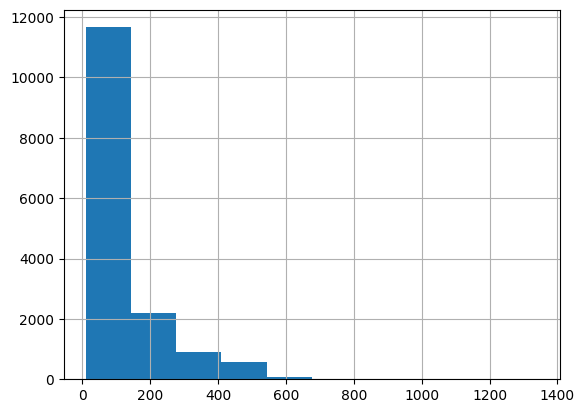

In [12]:
print('Mean ', rf['Flow'].mean())
print('Deviation ', rf['Flow'].std())
print('Maximum ', rf['Flow'].max())

rf['Flow'].hist()

### 2. Streamflow Training/Prediction

In [13]:
### Identify features (with either antecedent proxies or soil moisture levels)
days = 6
hours = 24
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
            + ['Temperature'] \
            + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] \
            + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)]\
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']) 
    
                
'''     
+ ['Snow Melt'] + ['Snow Melt-' + f'{d+1}' for d in range(days)] 
            + ['Rain_2h_mean', 'Rain_4h_mean', 'Rain_6h_mean']


+ [f"Rain_-{i+1}" for i in range(hours)]
+ ['Soil Moisture ' + f'{i+1}' for i in range(4)])
   
        #      + [f'Rain_{i//2}_2hourly' for i in range(0, 24, 2)]
            #+ ['Soil Moisture ' + f'{i+1}' for i in range(4)])
        + [f"Rain_{i}+1" for i in range(1,10)])
         + [f'Rain_{i//2}_2hourly' for i in range(0, 24, 2)]
            
            + ['Rain_2h_mean', 'Rain_4h_mean', 'Rain_6h_mean'])
             ['Delta_x'] + ['Delta_y'])
            + ['Rain_' + f'{d}' for d in range(hours)] \
            #
            #+ ['Delta_y-1'] + ['Delta_x-1'])
            #"
            '''
print(features)
print(len(features))

['Rain', 'Rain-1', 'Rain-2', 'Rain-3', 'Rain-4', 'Rain-5', 'Rain-6', 'Temperature', 'Temperature-1', 'Temperature-2', 'Temperature-3', 'Temperature-4', 'Temperature-5', 'Temperature-6', 'Resultant Windspeed', 'Resultant Windspeed-1', 'Resultant Windspeed-2', 'Resultant Windspeed-3', 'Resultant Windspeed-4', 'Resultant Windspeed-5', 'Resultant Windspeed-6', 'Humidity', 'Humidity-1', 'Humidity-2', 'Humidity-3', 'Humidity-4', 'Humidity-5', 'Humidity-6', 'Rain_28_Mu', 'Rain_90_Mu', 'Rain_180_Mu', 'Temperature_28_Mu', 'Temperature_90_Mu', 'Temperature_180_Mu']
34


In [14]:
import importlib
importlib.reload(load_data)
importlib.reload(train)

<module 'train_model.train' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\train.py'>

In [57]:
def full_training_loop(rf, features=features, loss_func=None, alpha=1.0, beta=1.0, grid_search=False, verbose=True):

    years_eval = [2010 + i for i in range(12)]
    #years_train = [1982,1983, 1991,1993,1997,2000]

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf, features, years_eval)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    # TRAINING
    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)   
    
    psi = ut.psi_distribution(y_train, 'lognorm', alpha=alpha, beta=beta, plot=verbose)
    
    network = train.train(x_train, 
                          y_train,
                          verbose=verbose, 
                          loss_func_type=loss_func, 
                          psi=psi[:len(x_train)], 
                          grid_search=grid_search)

    # EVALUATION
    x_test = load_data.reshape_input(full_set, xspace)  
    y_test = load_data.reshape_input(full_set, yspace)  
    x_test = torch.from_numpy(x_test).to(device)
    rf['Predicted'] = network.predict(x_test)

    if rf['Date'].dtype == 'float64':
        rf['Date'] = pd.to_datetime(rf['Date'], unit='s').dt.date
    testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
    return testrf, rf, network, y_test

#### 2a. Application to one site

In [58]:
importlib.reload(load_data)
importlib.reload(train)

<module 'train_model.train' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\train.py'>

Processing site " Severn at Haw Bridge "


C:\Users\aline\AppData\Local\Temp\ipykernel_40944\1225695067.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  hourly_df['Rain_2h_mean'] = hourly_df.rolling(window=2, axis=1).mean().iloc[1:, -1]
C:\Users\aline\AppData\Local\Temp\ipykernel_40944\1225695067.py:24: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  hourly_df['Rain_4h_mean'] = hourly_df.rolling(window=4, axis=1).mean().iloc[1:, -1]
C:\Users\aline\AppData\Local\Temp\ipykernel_40944\1225695067.py:25: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  hourly_df['Rain_6h_mean'] = hourly_df.rolling(window=6, axis=1).mean().iloc[1:, -1]


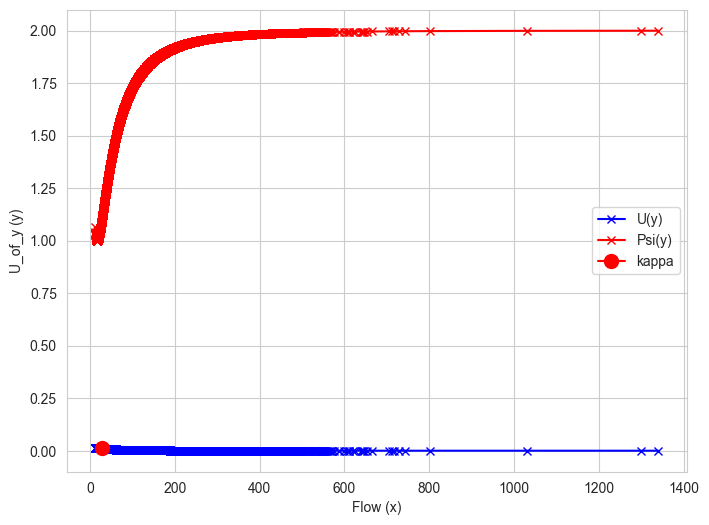

epoch 0, loss 24622.287109375
epoch 500, loss 5037.4658203125
epoch 1000, loss 2640.77197265625
epoch 1500, loss 2284.830322265625
epoch 2000, loss 2128.635009765625
epoch 2500, loss 1989.626708984375
epoch 3000, loss 1868.8355712890625
epoch 3500, loss 1752.65283203125
epoch 4000, loss 1655.75830078125
epoch 4500, loss 1556.5765380859375
epoch 5000, loss 1443.5936279296875
epoch 5500, loss 1315.5362548828125
Early stopping at epoch 5615, best validation loss: 1827.1597900390625


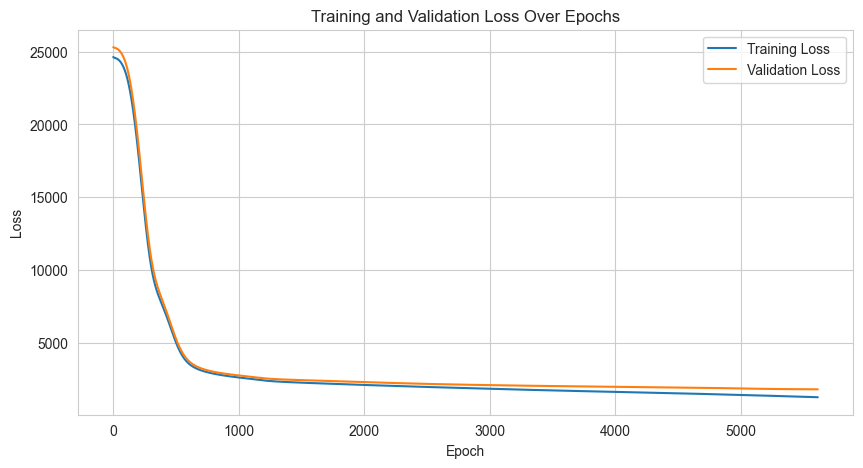

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


In [81]:
station_nr = 54057
df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
name = df.loc[df.index[3]].iloc[2]
print('Processing site "', name, '"')
    
boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)
rf = rf[:-1459]

# HOURLY INPUT
hourly_df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + f"/{station_nr}_daily_rain_9to9_linear.csv")
hourly_df = hourly_df.rename(columns={'date': 'Date'})
hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date
hourly_df = hourly_df.drop(rf.index[:365])

# 2-HOURLY INPUT
for i in range(1, 25, 2):
    col_name = f'Rain_{i//2}_2hourly'
    hourly_df[col_name] = hourly_df[f"Rain_-{i}"] + hourly_df[f"Rain_-{i+1}"]

# ROLLING MEANS OVER TIME WINDOWS
hourly_df['Rain_2h_mean'] = hourly_df.rolling(window=2, axis=1).mean().iloc[1:, -1]
hourly_df['Rain_4h_mean'] = hourly_df.rolling(window=4, axis=1).mean().iloc[1:, -1]
hourly_df['Rain_6h_mean'] = hourly_df.rolling(window=6, axis=1).mean().iloc[1:, -1]

'''
# PARAMETRISATION
hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_{i}" for i in range(24)]].sum()/24), axis=1)
hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)

# 9 HOURS FOR NEXT DAY (9am - 9am flow monitoring)
for variable in [f"Rain_{i}" for i in range(10)]:
    i = 1
    hourly_df[str(variable) + '+{0}'.format(i)] = hourly_df[variable].shift(-i)
    
# 24 HOURS PREVIOUS DAY
for variable in [f"Rain_{i}" for i in range(24)]:
    i = 1
    hourly_df[str(variable) + '-{0}'.format(i)] = hourly_df[variable].shift(-i)

'''
combined_rf = pd.merge(rf, hourly_df, on='Date')
combined_rf = combined_rf.dropna()

testrf_predicted, rf_predicted, network, y_test = full_training_loop(rf, features=features, loss_func=None, alpha=1, beta=2, grid_search=False) 
# loss_func ='Reflective'

2800


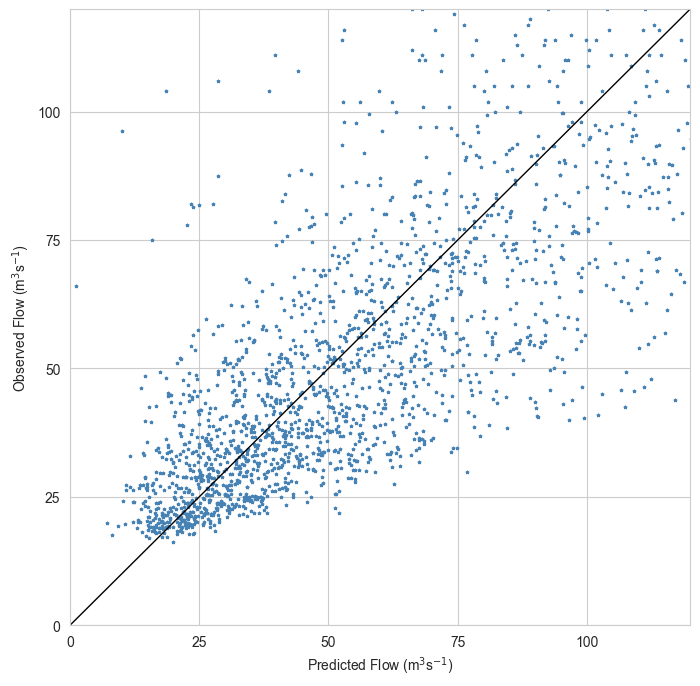

- - - - - - - - - - - - - - -
RMSE: 42.15906244152122
NSE: 0.8677296705579961
RE: 0.9206978300061173
13884


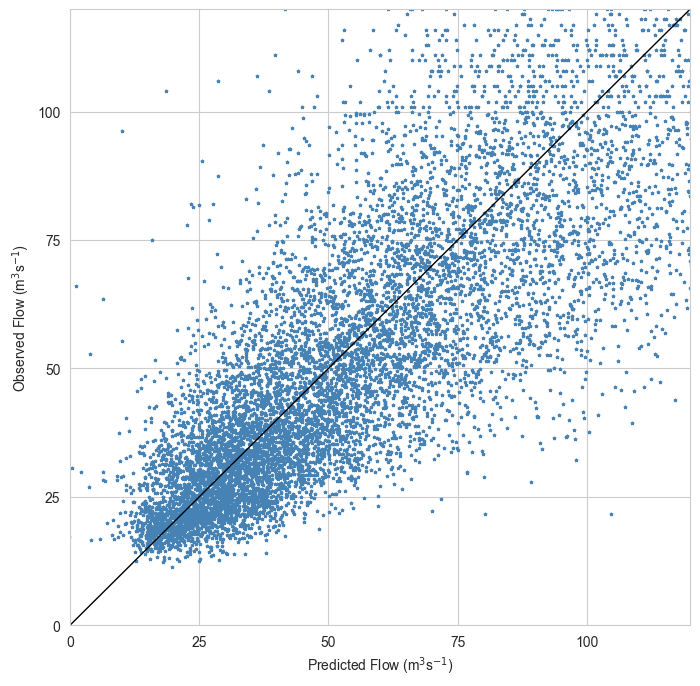

- - - - - - - - - - - - - - -
RMSE: 38.36377280775227
NSE: 0.8837010284725814
RE: 0.9224679868526449


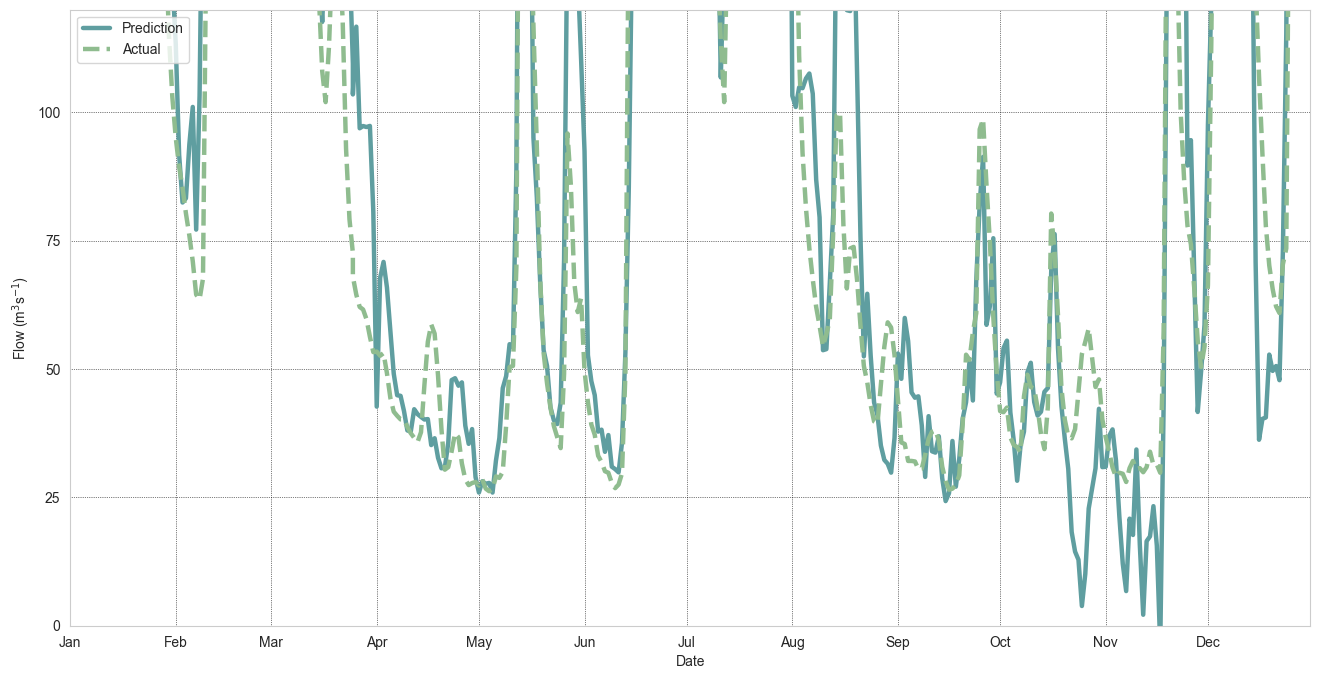

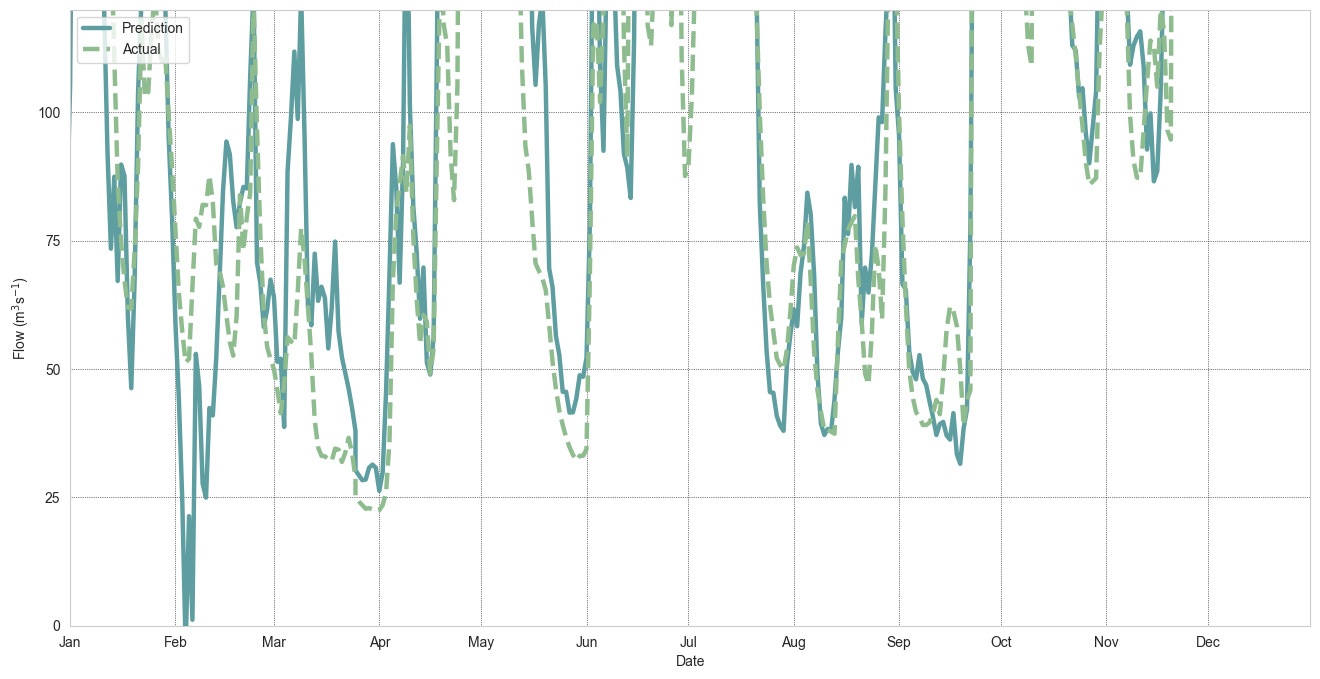

In [82]:
maxflow = 120

# recalculate PSI for alpha=1 and beta=1
psi_RE = ut.psi_distribution(y_test, 'lognorm')

for df in (testrf_predicted, rf_predicted):
    
    df = df.iloc[:-1]
    psi_df = psi_RE[-len(df):].squeeze()
    print(len(psi_df))

    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
strf.year_plot(maxflow, rf_predicted, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, rf_predicted, 'Predicted', 'Flow', 2012)  

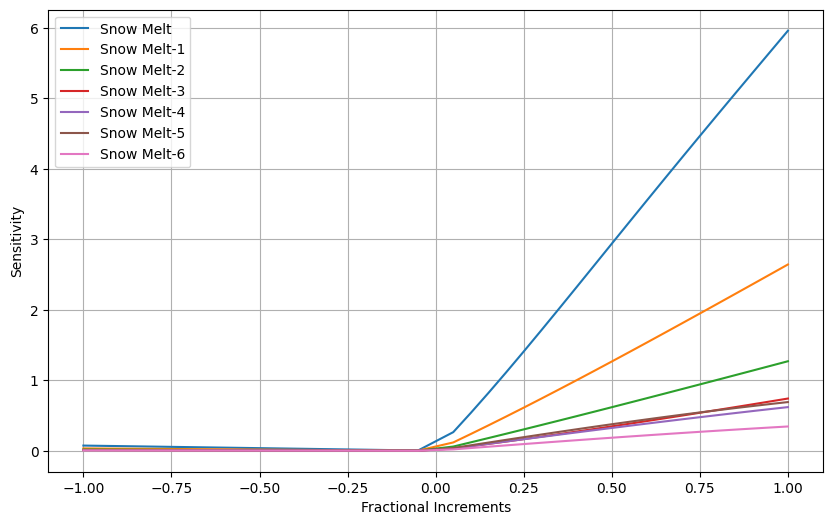

In [53]:
names = ['Rain', 'Temperature', 'Resultant Windspeed', 'Humidity']
names_rain = ['Rain'] + [f"Rain-{i}" for i in range(1,7)]
names_snow = ['Snow Melt'] + [f"Snow Melt-{i}" for i in range(1,7)]
names_temperature = ['Temperature'] + [f"Temperature-{i}" for i in range(1,7)]
names_windspeed = ['Resultant Windspeed'] + [f"Resultant Windspeed-{i}" for i in range(1,7)]
names_humidity = ['Humidity'] + [f"Humidity-{i}" for i in range(1,7)]
names_proxies = ['Rain_28_Mu', 'Rain_90_Mu', 'Rain_180_Mu', 
                 'Temperature_28_Mu', 'Temperature_90_Mu', 'Temperature_180_Mu']
names_proxies_temp = ['Temperature_28_Mu', 'Temperature_90_Mu', 'Temperature_180_Mu']
names_proxies_prec = ['Rain_28_Mu', 'Rain_90_Mu', 'Rain_180_Mu']
names_soil_moisture =  ['Soil Moisture ' + f'{i+1}' for i in range(4)]
names_hourly_rain = [f"Rain_{i}" for i in range(0,24)]
names_2hourly_rain = [f'Rain_{i//2}_2hourly' for i in range(0, 24, 2)]
names_rain_params = ['Delta_x', 'Delta_y']
names_next_day_rain = [f"Rain_{i}+1" for i in range(1,10)]
names_prev_day_rain = [f"Rain_{i}-1" for i in range(12, 24)]
names_rain_various_means = ['Rain_2h_mean', 'Rain_4h_mean', 'Rain_6h_mean']

names_custom = [f"Rain_{i}" for i in range(9,24)] + [f"Rain_{i}+1" for i in range(1,10)]

sf = sa.perform_sensitivity_analysis(network, features, rf_predicted, names_snow)
sa.plot_sensitivities(sf, names_snow)

In [105]:
rf_predicted['error'] = rf_predicted['Predicted'] - rf_predicted['Flow']
rf_predicted['MAPE'] = (rf_predicted['Predicted'] - rf_predicted['Flow'])/rf_predicted['Predicted']

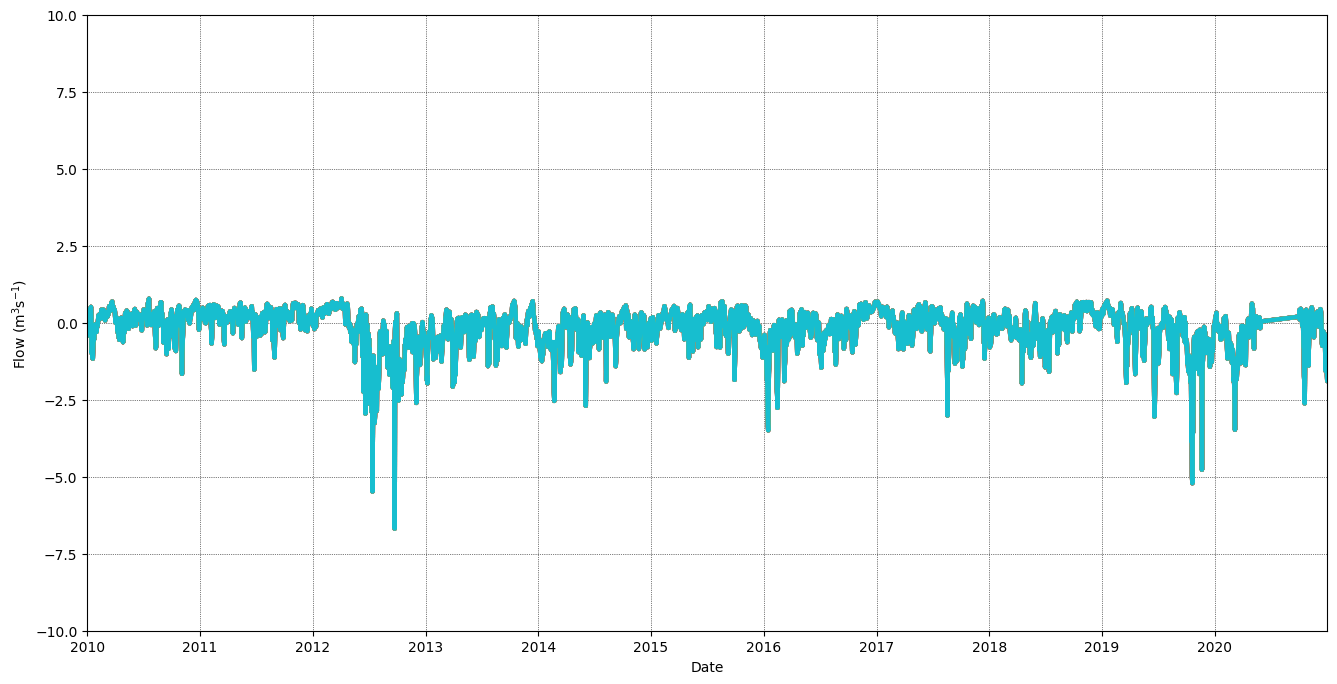

In [106]:
import datetime as dt

year = 2012

fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Date')
ax.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')

year1 = 2010
year2 = 2020

for year in range(year1,year2):
    
    #df_select = df[pd.to_datetime(df['Date']).dt.year.isin([str(year)])]
    #print(df_select)
    
    ax.plot(rf_predicted['Date'], rf_predicted['MAPE'], lw=3.2)

ax.set_xlim([dt.date(year1, 1, 1), dt.date(year2, 12, 31)])
ax.set_ylim(-10,10)

ax.grid(c='black', ls='dotted', lw=0.5)
plt.show()

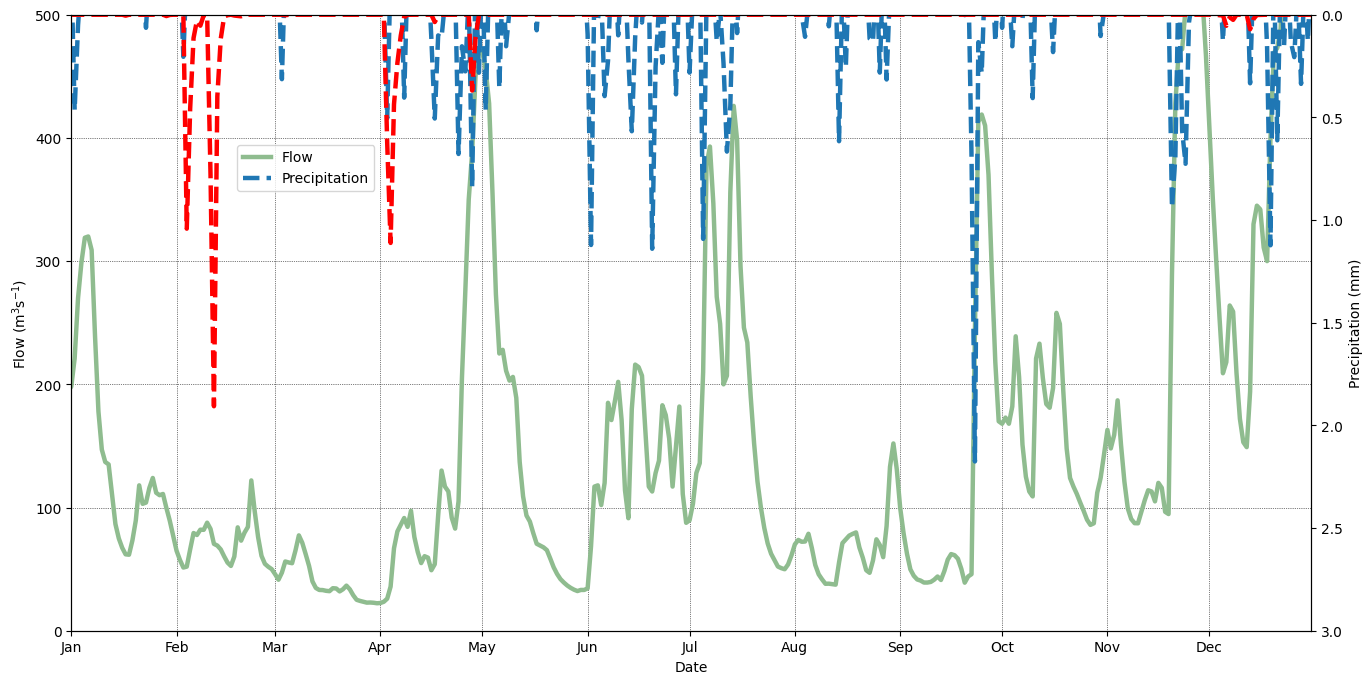

In [109]:
import matplotlib.dates as mdt
import matplotlib.ticker as mtk
import matplotlib.pyplot as plt
import numpy as np

def hydroVrain(maxflow, maxrain, xf, flow, rain, year, colour1='cadetblue',

               colour2='darkseagreen', maxsnow=None, snow=None):

    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])

    ax1.set_xlabel('Date')

    ax1.xaxis.set_major_locator(mdt.MonthLocator())

    ax1.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

    ax1.set_ylim(0,maxflow)

    ax1.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')

    ax1.yaxis.set_major_locator(mtk.MaxNLocator(5))

    ax1.grid(c='black', ls='dotted', lw=0.5)

    ax1.plot(xf['Date'], xf[flow], colour2, lw=3.2, label='Flow')

    ax1.plot(np.nan, colour1, lw=3.2, label='Precipitation', ls='--')

    ax2 = ax1.twinx()

    ax2.set_ylabel('Precipitation (mm)')

    ax2.set_ylim(maxrain,0)

    ax2.plot(xf['Date'], xf[rain], colour1, lw=3.2, ls='--')
    
    if snow is not None:
        ax2.plot(xf['Date'], xf[snow], 'red', lw=3.2, ls='--')

    ax1.legend(loc=0, bbox_to_anchor=(0.25,0.8))

    plt.show()
    
hydroVrain(500, 3, rf, 'Flow', 'Rain', 2012, 15, snow='Snow Melt')

In [135]:
network

NeuralNetworkRegressor(dropout_rate=0.2, input_size=38, learning_rate=0.005,
                       weight_decay=0.01)

In [34]:
overview = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped.csv'), verbose=False)[['Date', 'Flow']]

overview['Psi'] = psi_RE

# compare with 
pd.read_csv(paths.CATCHMENT_BASINS + '/45009/ReflectiveError_Pixton.csv')

ValueError: Length of values (15341) does not match length of index (15527)

#### 2b. Application on all the sites together

Processing site " Dee at Polhollick "


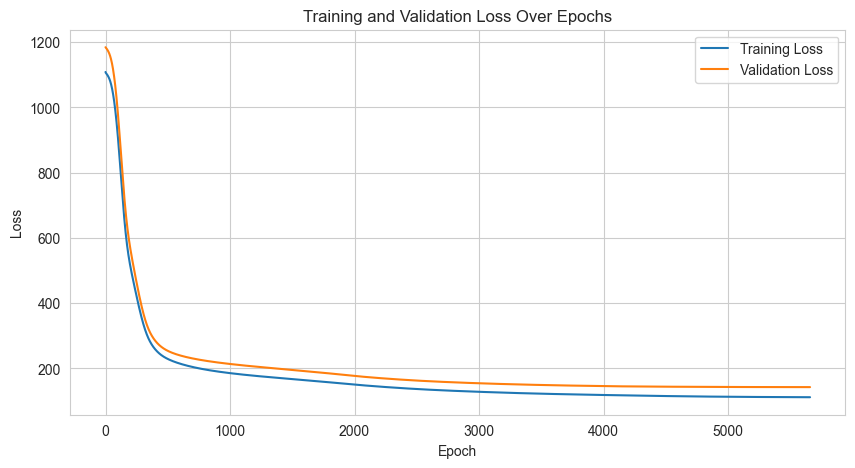

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
C:\Users\aline\AppData\Local\Temp\ipykernel_40944\572495168.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_gdf = pd.concat([results_gdf, new_data], ignore_index=True)


Processing site " Devon at Glenochil "


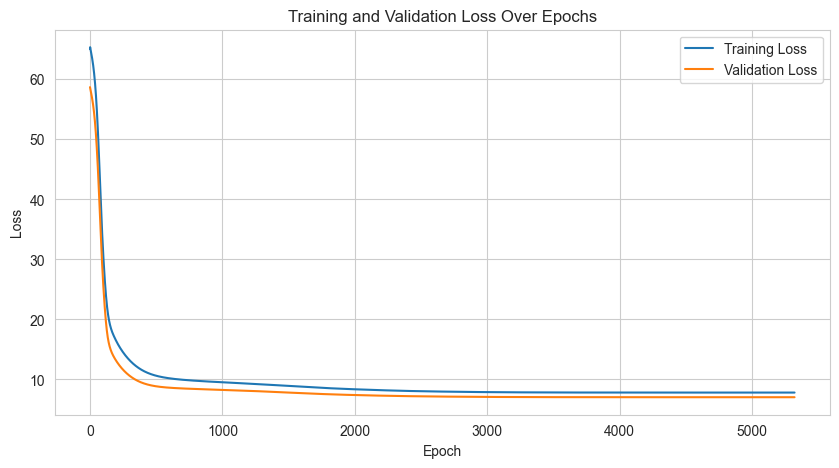

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Coquet at Morwick "


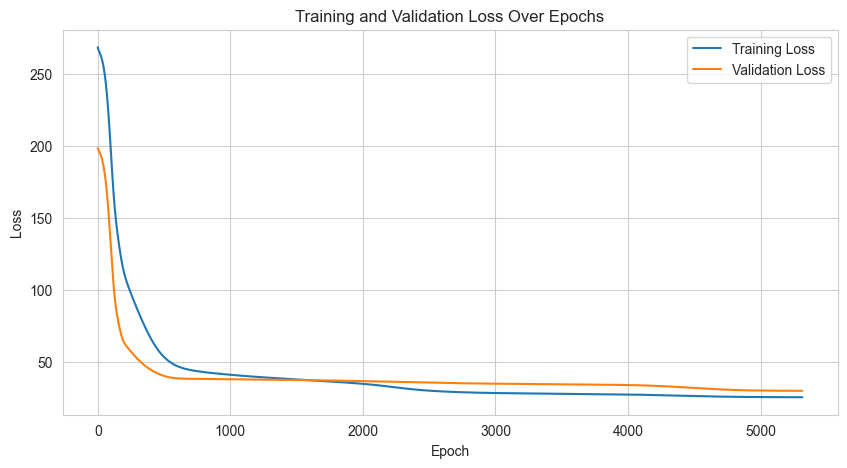

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Ure at Westwick "


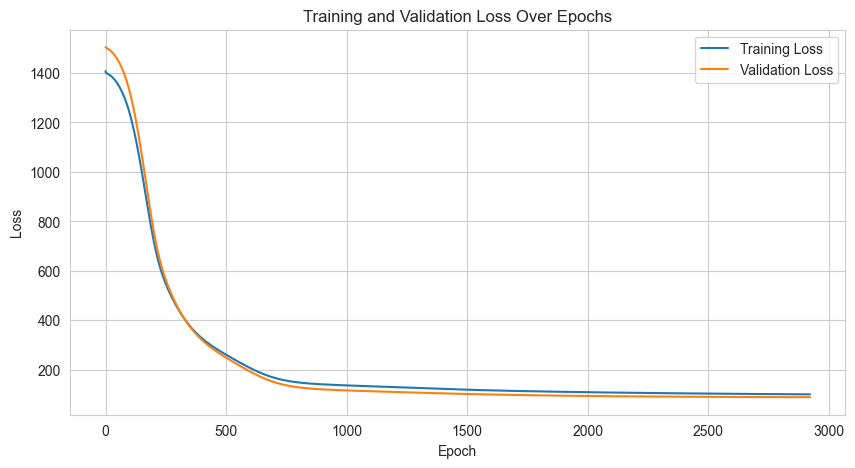

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Swale at Crakehill "


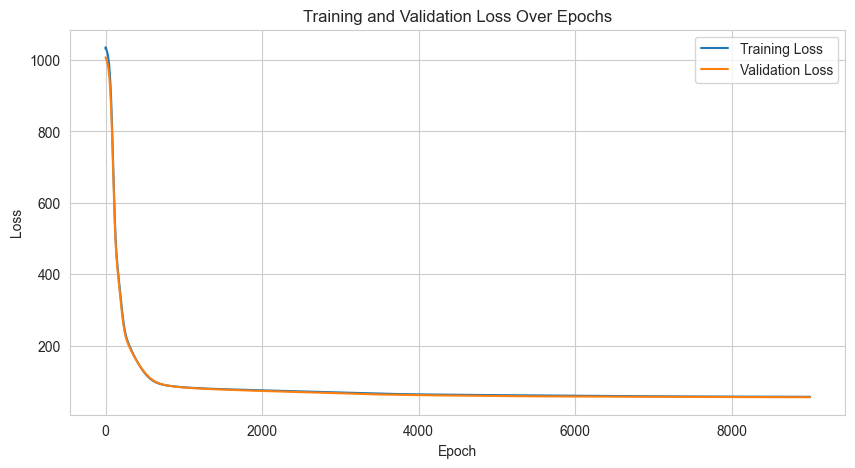

C:\Users\aline\soil-moisture-proxies\train_model\train.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Processing site " Derwent at Malton A64 Road Bridge "


ValueError: zero-size array to reduction operation minimum which has no identity

In [78]:
results_gdf = gp.GeoDataFrame(columns=['Station', 'Name', 'NSE', 'HE_mean', 'HE_std', 'Geometry'])
#sf_summary = pd.DataFrame({'Variable': names_rain})

for station_nr in os.listdir(paths.CATCHMENT_BASINS):
    
    df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    print('Processing site "', name, '"')
    
    boundary = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
    rf = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
    
    '''
    hourly_df = pd.read_csv(paths.CATCHMENT_BASINS + '/' + str(station_nr) + f"/{station_nr}_daily_rain.csv")
    hourly_df = hourly_df.rename(columns={'date': 'Date'})
    hourly_df['Date'] = pd.to_datetime(hourly_df['Date'], format='%Y-%m-%d').dt.date
    hourly_df = hourly_df.drop(rf.index[:365])
    
    # 2-HOURLY INPUT
    for i in range(0, 24, 2):
        col_name = f'Rain_{i//2}_2hourly'
        hourly_df[col_name] = hourly_df[f"Rain_{i}"] + hourly_df[f"Rain_{i+1}"]


    hourly_df['Delta_y'] =  hourly_df.apply(lambda row: (row.iloc[1:].max() - row[[f"Rain_{i}" for i in range(24)]].sum()/24), axis=1)
    hourly_df['Delta_x'] = hourly_df.apply(lambda row: (24 - int(row.iloc[1:].idxmax().split('_')[1]))/24, axis=1)

    combined_rf = pd.merge(rf, hourly_df, on='Date')
    '''
    
    testrf, rf_predicted, network, _ = full_training_loop(rf, verbose=False)
 
    # Calculate the NSE
    NSE = me.R2(testrf['Flow'], testrf['Predicted'])
    
    # Calculate the hydraulic efficiency
    HE_mean = (rf_predicted['Flow'].mean()/boundary.geometry.area)*(10^6)
    HE_std = (rf_predicted['Flow'].std()/boundary.geometry.area)*(10^6)

    # Assuming 'results_gdf' is your existing GeoDataFrame
    new_data = gp.GeoDataFrame({
        'Station': station_nr,
        'Name': name, 
        'NSE': NSE,
        'HE_mean': HE_mean,
        'HE_std': HE_std, 
        'Geometry': boundary.geometry.iloc[0]
    })

    results_gdf = pd.concat([results_gdf, new_data], ignore_index=True)
    
    #sf = sa.perform_sensitivity_analysis(network, features, rf_predicted, names_proxies)
    #sf_summary[f"{station_nr}_+0.5"] = sf["+0.5"]
    #sf_summary[f"{station_nr}_+1.0"] = sf["+1.0"]
    
results_gdf    

In [173]:
proxies = ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']

sf_summary = sf_summary[:-1]
sf_summary['Variable'] = proxies
sf_summary

Variable  12003_+0.5  12003_+1.0  18002_+0.5  18002_+1.0  \
0          Rain_28_Mu    1.513791    3.097095    0.733885    1.577664   
1          Rain_90_Mu    0.340195    0.438536    0.236677    0.483151   
2         Rain_180_Mu    0.179418    0.341981    0.141034    0.304311   
3   Temperature_28_Mu    0.349451    0.179771    0.343286    0.617711   
4   Temperature_90_Mu    0.212920    0.040053    0.208138    0.387700   
5  Temperature_180_Mu    0.129181    0.495784    0.320514    0.672757   

   22001_+0.5  22001_+1.0  27007_+0.5  27007_+1.0  27071_+0.5  ...  7001_+0.5  \
0    3.011371    5.305228    1.036491    1.941333    1.180484  ...   0.725395   
1    0.367685    0.473884    0.174974    0.280676    0.130739  ...   0.064853   
2    0.380435    0.757620    0.223404    0.398356    0.247279  ...   0.178611   
3    0.617570    0.750798    0.329080    0.504937    0.385930  ...   0.380367   
4    0.369877    0.475045    0.411256    0.695626    0.508701  ...   0.322530   
5    0.578227    0.978223    0.406995    0.820743    0.459116  ...   0.224898   

   7001_+1.0  72016_+0.5  72016_+1.0  8002_+0.5  8002_+1.0  9004_+0.5  \
0   0.947505    0.493163    1.024480   1.671684   3.731715   0.733624   
1   0.002391    0.144572    0.276245   0.276474   0.561835   0.164901   
2   0.302244    0.067521    0.153058   0.290228   0.574879   0.315234   
3   0.228195    0.306704    0.556768   0.252590   0.091395   0.266436   
4   0.794088    0.124906    0.280005   0.297123   0.194207   0.078966   
5   0.343822    0.084979    0.203359   0.361642   0.952828   0.057572   

   9004_+1.0  95002_+0.5  95002_+1.0  
0   1.848397    0.805923    1.610713  
1   0.323926    0.107154    0.224836  
2   0.680671    0.004260    0.022247  
3   0.495408    0.066568    0.068419  
4   0.151071    0.078096    0.116389  
5   0.112720    0.145129    0.299075  

[6 rows x 53 columns]

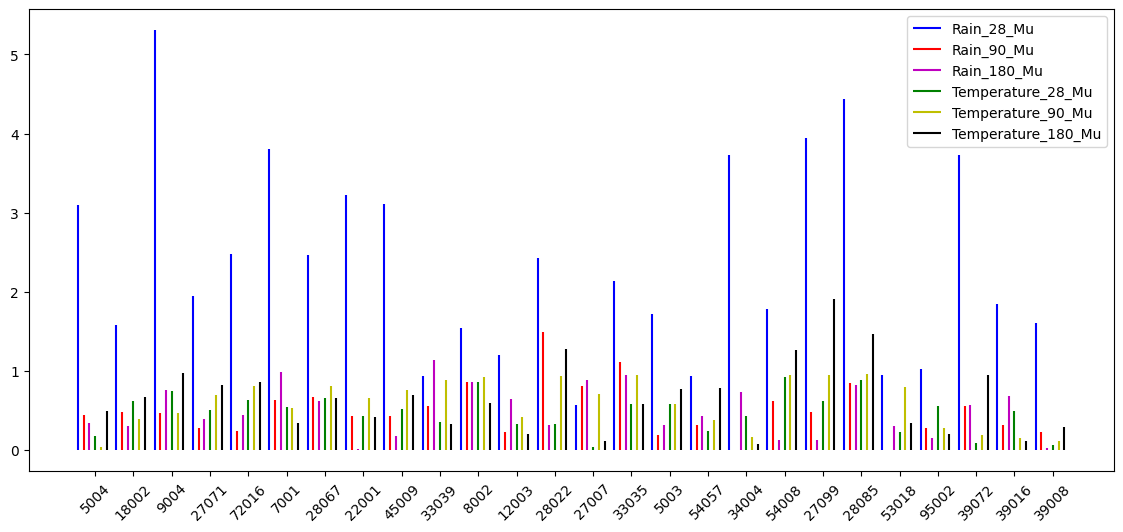

In [176]:
def retrieve_sensitivity(sf_summary, station_nr, sensitivity_degree, feature):
    
    sf_feature = sf_summary[sf_summary['Variable'] == feature]
    return sf_feature.loc[sf_feature.index[0], f"{station_nr}_+{sensitivity_degree}"]

#retrieve_sensitivity(sf_summary, 12003, 0.5, 'Rain')

sorted_results = results_gdf.sort_values(by='NSE')

plt.figure(figsize=(14, 6))

feature = 'Rain-1'
bar_width = 0.15
station_labels = sorted_results['Station'].unique()

features = ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
colors = ['b', 'r', 'm', 'g', 'y', 'k']

labels_added = {feature: False for feature in features}

# Plot vertical lines for each feature
for index, row in sorted_results.iterrows():
    for i, feature in enumerate(features):
        color = colors[i]
        x_offset = (i - 3) * bar_width  # Adjust the x position to avoid overlap
        
        # Only add the label once
        label = feature if not labels_added[feature] else ""
        labels_added[feature] = True

        plt.vlines(x=index + x_offset, ymin=0, ymax=retrieve_sensitivity(sf_summary, row['Station'], sensitivity_degree=1.0, feature=feature), colors=color, linestyles='solid', label=label)
    
plt.xticks(ticks=range(len(station_labels)), labels=station_labels, rotation=45)
plt.legend()
plt.show()

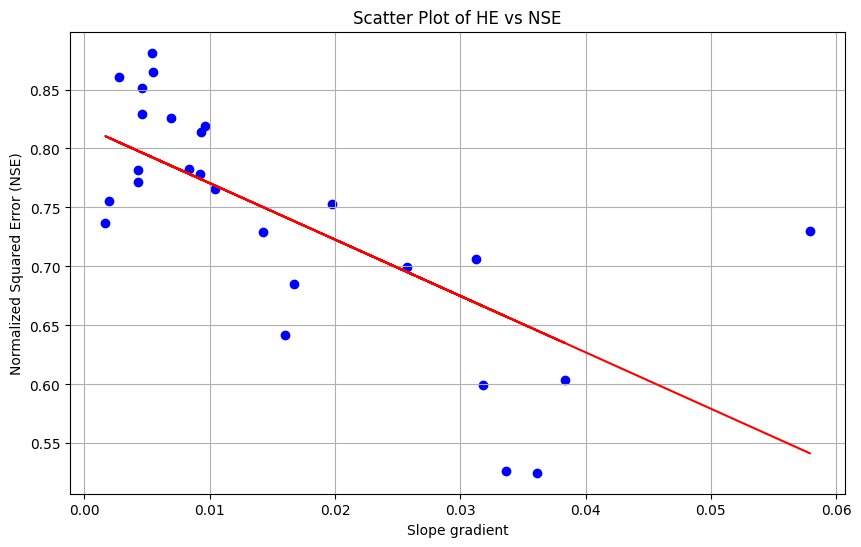

In [25]:
import matplotlib.pyplot as plt

param_to_plot= 'Slope gradient'#'HE_mean'

plt.figure(figsize=(10, 6))

# Scatter plot for the mean values
plt.scatter(results_gdf[param_to_plot], results_gdf['NSE'], color='blue', marker='o')

# Error bars for the standard deviation
#plt.errorbar(results_gdf['HE_mean'], results_gdf['NSE'], xerr=results_gdf['HE_std'], fmt='o', color='blue', capsize=5)

# Adding labels and title
plt.xlabel(f"{param_to_plot}")
plt.ylabel('Normalized Squared Error (NSE)')
plt.title('Scatter Plot of HE vs NSE')

# Optional: Adding a line of best fit to help visualize any linear trend
import numpy as np
m, b = np.polyfit(results_gdf[param_to_plot], results_gdf['NSE'], 1)
plt.plot(results_gdf[param_to_plot], m*results_gdf[param_to_plot] + b, color='red')  # Line of best fit

plt.grid(True)
plt.show()

In [340]:
from shapely import Point

def find_longest_diagonal(polygon):
    box = polygon.minimum_rotated_rectangle
    x, y = box.exterior.coords.xy

    # get length of bounding box edges
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_length)

results_gdf['Cross_distance'] = results_gdf['Geometry'].apply(lambda geometry: find_longest_diagonal(geometry)) 
results_gdf['Area']= results_gdf['Geometry'].apply(lambda geometry: geometry.area)

In [341]:
metadata = pd.read_csv(paths.DATA + '/Catchments_Fens.csv')

results_gdf['Minimum altitude'] = results_gdf['Station'].apply(lambda station: metadata[metadata['Station number'] == int(station)]['Minimum altitude'].iloc[0])
results_gdf['Maximum altitude'] = results_gdf['Station'].apply(lambda station: metadata[metadata['Station number'] == int(station)]['Maximum altitude'].iloc[0])
results_gdf['Height difference'] = results_gdf['Maximum altitude'] - results_gdf['Minimum altitude']
results_gdf['Slope gradient'] = results_gdf['Height difference']/results_gdf['Cross_distance']

In [103]:
results_gdf

Station                               Name       NSE       HE_mean  \
0    12003                  Dee at Polhollick  0.700921  4.077777e-07   
1    18002                 Devon at Glenochil  0.600896  3.501415e-07   
2    22001                  Coquet at Morwick  0.691732  1.836751e-07   
3    27071                 Swale at Crakehill  0.771391  1.852439e-07   
4    27099  Derwent at Malton A64 Road Bridge  0.827494  1.416165e-07   
5    28067            Derwent at Church Wilne  0.777807  1.950332e-07   
6    28085        Derwent at St Mary's Bridge  0.806515  1.994347e-07   
7    33035         Ely Ouse at Denver Complex  0.735408  5.113488e-08   
8    33039             Bedford Ouse at Roxton  0.778438  8.513027e-08   
9    34004           Wensum at Costessey Mill  0.753925  8.911289e-08   
10   39008                  Thames at Eynsham  0.882008  1.064532e-07   
11   39016                   Kennet at Theale  0.783379  1.129218e-07   
12   45009                      Exe at Pixton  0.728403  3.757230e-07   
13    5003               Glass at Kerrow Wood  0.705217  7.663366e-07   
14    5004                 Glass at Fasnakyle  0.524716  2.097820e-07   
15   53018                   Avon at Bathford  0.826325  1.505048e-07   
16   54008                    Teme at Tenbury  0.817005  1.602878e-07   
17   54057               Severn at Haw Bridge  0.851666  1.371884e-07   
18    7001              Findhorn at Shenachie  0.654558  4.234142e-07   
19   72016               Wyre at Scorton Weir  0.606031  4.474353e-07   
20    8002                    Spey at Kinrara  0.751145  2.956321e-07   
21    9004                  Bogie at Redcraig  0.524619  2.105348e-07   
22   95002                Broom at Inverbroom  0.722616  6.141976e-07   

          HE_std                                           Geometry  \
0   4.156071e-07  POLYGON ((334425.00009999983 796575.0000999998...   
1   4.354216e-07  POLYGON ((285800.00009999983 696025.0000999998...   
2   2.869327e-07  POLYGON ((423475.00009999983 604450.0000999998...   
3   2.148020e-07  POLYGON ((442525.00009999983 473300.0000999998...   
4   1.200397e-07  POLYGON ((481175.00009999983 473075.0000999998...   
5   1.997474e-07  POLYGON ((444175.00009999983 331650.0000999998...   
6   1.966020e-07  POLYGON ((435350.00009999983 336875.0000999998...   
7   4.705311e-08  POLYGON ((558925.0000999998 300975.00009999983...   
8   1.008762e-07  POLYGON ((516025.00009999983 253525.0000999998...   
9   6.251573e-08  POLYGON ((617650.0000999998 312775.00009999983...   
10  1.150044e-07  POLYGON ((444525.00009999983 208700.0000999998...   
11  7.233785e-08  POLYGON ((464975.00009999983 170850.0000999998...   
12  4.307143e-07  POLYGON ((293525.00009999983 125975.0000999998...   
13  5.649712e-07  POLYGON ((235475.00009999983 832100.0000999998...   
14  3.315644e-07  POLYGON ((231575.00009999983 828750.0000999998...   
15  1.903644e-07  POLYGON ((378525.00009999983 167025.0000999998...   
16  2.066249e-07  POLYGON ((359775.00009999983 268500.0000999998...   
17  1.398227e-07  POLYGON ((384500.00009999983 227875.0000999998...   
18  5.415733e-07  POLYGON ((282575.00009999983 833550.0000999998...   
19  7.040821e-07  POLYGON ((350075.00009999983 449975.0000999998...   
20  2.965888e-07  POLYGON ((288125.00009999983 808225.0000999998...   
21  1.883827e-07  POLYGON ((351950.00009999983 837475.0000999998...   
22  8.785551e-07  POLYGON ((218400.00009999983 884225.0000999998...   

            Area  Cross_distance  Minimum altitude  Maximum altitude  \
0   6.975003e+08    42293.346798             219.6            1308.9   
1   1.786850e+08    22491.447241               4.4             720.5   
2   5.782494e+08    45951.263162               5.2             774.5   
3   1.354417e+09    75623.598152              14.6             714.3   
4   1.382881e+09    63654.751743              15.2             453.2   
5   1.176617e+09    72209.835522              30.7             635.5   
6   1.051008e+09    63617.961501         

In [128]:
# Assuming 'results_gdf' is your GeoDataFrame with 'HE', 'NSE', and 'Station' columns
fig = px.scatter(results_gdf, x='HE_mean', y='NSE', text='Station', 
                 hover_data=['Station'],  # This specifies what data to show on hover
                 title='Interactive Plot of HE vs NSE')

# Adding labels
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color='DarkSlateGrey')), 
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_xaxes(title_text='Hydraulic Efficiency (HE)')
fig.update_yaxes(title_text='Normalized Squared Error (NSE)')

# Show the plot
fig.show()

In [102]:
# Assuming 'results_gdf' is your GeoDataFrame with 'HE', 'NSE', and 'Station' columns
fig = px.scatter(results_gdf, x='HE', y='NSE', text='Station', 
                 hover_data=['Station'],  # This specifies what data to show on hover
                 title='Interactive Plot of HE vs NSE')

# Adding labels
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color='DarkSlateGrey')), 
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.update_xaxes(title_text='Hydraulic Efficiency (HE)')
fig.update_yaxes(title_text='Normalized Squared Error (NSE)')

# Show the plot
fig.show()

In [ ]:
testrf, rf, network, psi = full_training_loop(rf, features=feature_set, loss_func=None)  # loss_func ='Reflective'
maxflow = 300

for df in (testrf, rf):

    if len(df) > len(psi.squeeze()):
        psi_df = np.mean(psi)
    else:
        psi_df = psi[-len(df):].squeeze()

    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2012)

In [28]:
rf_predicted

Unnamed: 0        Date    Flow  Temperature  U Windspeed  V Windspeed  \
0             365  1980-01-01  16.230   269.838962     1.088017     0.375745   
1             366  1980-01-02  28.750   270.510907    -0.320674     1.454804   
2             367  1980-01-03  20.300   277.368000    -0.604044     2.216654   
3             368  1980-01-04  17.460   278.237790     1.725975     4.857943   
4             369  1980-01-05  31.670   279.206133     4.647045     1.372286   
...           ...         ...     ...          ...          ...          ...   
15336       15701  2021-12-27   6.629   278.783497    -0.496029     1.618723   
15337       15702  2021-12-28   8.270   278.013985     0.233542     0.743381   
15338       15703  2021-12-29  27.620   279.755530    -2.302576     2.796058   
15339       15704  2021-12-30  40.830   285.346900     3.526217     3.450856   
15340       15705  2021-12-31  14.750   284.123018    -0.664250     0.774177   

         Humidity      Rain  Resultant Windspeed    Rain-1  ...       Rain_17  \
0       99.694736  0.059530             1.151071  0.346565  ...  8.673617e-16   
1       98.062561  0.138724             1.489727  0.059530  ...  8.673617e-16   
2       91.163276  4.981409             2.297482  0.138724  ...  1.427120e+00   
3       83.237617  1.186570             5.155443  4.981409  ...  7.584329e-04   
4       89.137954  3.803181             4.845430  1.186570  ...  7.584564e-03   
...           ...       ...                  ...       ...  ...           ...   
15336   95.908227  1.710861             1.693018  0.198059  ...  1.386184e-02   
15337  100.357242  0.321579             0.779203  1.710861  ...  5.588928e-03   
15338   91.132859  8.542511             3.622125  0.321579  ...  8.673617e-16   
15339   92.228023  3.634520             4.933823  8.542511  ...  5.132988e-03   
15340   99.356866  2.545359             1.020087  3.634520  ...  3.102519e-04   

            Rain_18       Rain_19       Rain_20       Rain_21       Rain_22  \
0      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
1      8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
2      5.829091e-01  4.688797e-01  2.005692e-01  4.086575e-02  1.706386e-03   
3      7.584329e-04  1.332655e-03  1.232446e-03  3.033732e-04  1.518239e-03   
4      9.149028e-03  6.808934e-03  4.692837e-03  4.118998e-03  1.842919e-03   
...             ...           ...           ...           ...           ...   
15336  1.110505e-02  5.315566e-02  1.723305e-02  6.171387e-04  1.537307e-04   
15337  1.562533e-03  8.673617e-16  8.673617e-16  8.673617e-16  8.673617e-16   
15338  8.673617e-16  2.183616e-03  8.477776e-03  1.190498e-02  2.626720e-01   
15339  2.057091e-03  4.003197e-03  2.686365e-03  4.069996e-04  7.584329e-04   
15340  8.673617e-16  1.468344e-03  1.042730e-03  7.584329e-04  2.395835e-03   

            Rain_23   Delta_y   Delta_x  Predicted  
0      8.673617e-16 -0.057094  0.088599  18.800892  
1      8.673617e-16 -0.057831  0.479904  18.779905  
2      1.568344e-03  0.082403 -0.259227  21.280563  
3      1.839193e-03 -0.027308  0.262512  19.137968  
4      1.085882e-03 -0.045121  0.088599  18.395203  
...             ...       ...       ...        ...  
15336  3.603563e-04 -0.023754 -0.085314  20.159039  
15337  8.673617e-16  0.142137  0.219034  21.139091  
15338  4.618905e-01  0.079254  0.219034  20.447845  
15339  3.627532e-03 -0.035657 -0.041836  19.193726  
15340  2.331020e-01  0.027760  0.175556  19.453682  

[15341 rows x 160 columns]

In [29]:
rf

Unnamed: 0        Date    Flow  Temperature  U Windspeed  V Windspeed  \
0             179  1979-06-29   9.654   282.597922     4.351510     0.944776   
1             180  1979-06-30   9.730   281.037347     3.683683    -2.257421   
2             181  1979-07-01   5.846   284.745207     4.448323    -0.333201   
3             182  1979-07-02   4.232   285.430259     4.511554     1.384902   
4             183  1979-07-03   3.607   288.045634     2.799352     0.458577   
...           ...         ...     ...          ...          ...          ...   
15522       15701  2021-12-27   6.629   278.783497    -0.496029     1.618723   
15523       15702  2021-12-28   8.270   278.013985     0.233542     0.743381   
15524       15703  2021-12-29  27.620   279.755530    -2.302576     2.796058   
15525       15704  2021-12-30  40.830   285.346900     3.526217     3.450856   
15526       15705  2021-12-31  14.750   284.123018    -0.664250     0.774177   

         Humidity      Rain  Resultant Windspeed    Rain-1  ...  Humidity-25  \
0       83.392270  4.181380             4.452891  0.889576  ...    64.267386   
1       65.197735  0.687574             4.320355  4.181380  ...    95.441513   
2       69.357659  0.717311             4.460785  0.687574  ...    50.771453   
3       78.912652  0.100297             4.719330  0.717311  ...    69.790185   
4       65.002569  0.010104             2.836665  0.100297  ...    82.045220   
...           ...       ...                  ...       ...  ...          ...   
15522   95.908227  1.710861             1.693018  0.198059  ...    80.461920   
15523  100.357242  0.321579             0.779203  1.710861  ...    88.843707   
15524   91.132859  8.542511             3.622125  0.321579  ...   100.360697   
15525   92.228023  3.634520             4.933823  8.542511  ...    85.343486   
15526   99.356866  2.545359             1.020087  3.634520  ...    86.057290   

       Humidity-26  Humidity-27  Humidity_28_Mu  Humidity_90_Mu  \
0        56.077831    47.931047       69.844041       68.247992   
1        64.267386    56.077831       70.460709       68.130295   
2        95.441513    64.267386       70.934988       68.203607   
3        50.771453    95.441513       71.458033       68.137718   
4        69.790185    50.771453       70.370928       68.128275   
...            ...          ...             ...             ...   
15522    87.395167    98.857542       89.743646       84.737522   
15523    80.461920    87.395167       89.797206       85.120314   
15524    88.843707    80.461920       89.930696       85.148567   
15525   100.360697    88.843707       90.350913       85.317746   
15526    85.343486   100.360697       90.726383       85.681141   

       Humidity_180_Mu  Soil Moisture 1  Soil Moisture 2  Soil Moisture 3  \
0            75.545634         0.254181         0.243434         0.219750   
1            75.436394         0.246692         0.243917         0.219100   
2            75.346883         0.235974         0.239829         0.218229   
3            75.310331         0.230940         0.236197         0.217307   
4            75.141033         0.219441         0.230287         0.215837   
...                ...              ...              ...              ...   
15522        78.166031         0.271568         0.266287         0.282178   
15523        78.481938         0.262474         0.264933         0.281010   
15524        78.690262         0.311028         0.263023         0.279705   
15525        78.807802         0.316017         0.309548         0.282402   
15526        78.971922         0.293488         0.297948         0.287132   

       Soil Moisture 4  
0             0.276735  
1             0.276375  
2             0.275998  
3             0.275635  
4             0.275231  
...                ...  
15522         0.286019  
15523         0.285985  
15524         0.285942  
15525         0.285897  
15526         0.285937  

[15527 rows x 133 columns]